## imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
import matplotlib.pyplot as plt
import time

/home/uttam/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import torch

## function & derivatives

In [3]:
"""
The Ackley function.

  Args:
    x: A numpy array of the input values.

  Returns:
    The value of the Ackley function at the given input.
"""

def ackley(x):
    x = x.astype('float32')
    n = x.shape[0]
    d = x.shape[1]

    a = 20
    b = 0.2
    c = 2 * np.pi
    e = np.exp(1)

    sum1 = np.sum(x**2, axis = 1)
    sum2 = np.sum(np.cos(c*x), axis = 1)
    

    f = -a * np.exp(-b * np.sqrt(sum1/d)) - np.exp(sum2/d) + e + a

    return f.astype('float32')

    # this function returns the function (n x 1) and gradf values (n x d) where n is number of particles an d is dimension of x

In [4]:
def ackley_grad(x):
    x = x.astype('float32')
    n = x.shape[0]
    d = x.shape[1]
    component = np.arange(N)
    a = 20
    b = 0.2
    c = 2 * np.pi
    e = np.exp(1)

    sum1 = np.sum(x**2, axis = 1).reshape(-1,1)
    sum2 = np.sum(np.cos(c*x), axis = 1).reshape(-1,1)
        
    gradf = np.zeros((n,len(component)), dtype = 'float32')
    
    term1 = (-a * np.exp(-b * np.sqrt(sum1/d)) * (-b/np.sqrt(d * sum1 + 1e-16))) * x[:,component]
    term2 = -np.exp(sum2/d) * (-c/d) * np.sin(c * x[:,component])
    gradf[:,:] = (term1 + term2)

    return gradf.astype('float32')

## func, xmean, dim

In [5]:
N = 5000
strfitnessfct = ackley
strgrad = ackley_grad
xmean = 0.1 * np.ones((N,1)) #+ 0.01* np.random.randn(N,1)

In [6]:
xmean.shape

(5000, 1)

## initialisations

In [7]:
stopfitness = 1e-12

In [8]:
xmean = xmean.astype('float32')
xmin = xmean

In [9]:
R = 0.1 * np.ones((1,N))
Γ = np.zeros((N,1), dtype = np.float32)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.9
Δ = 0
x_st = xmean
fXX = (strfitnessfct(xmean.T))

## helper functions

In [10]:
def generate_arx(x, r, num = 5):
    return np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1)

In [11]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y = strfitnessfct(x.T)
        y_grad = strgrad(x.T).T
        
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x.T)
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [12]:
def calc_invH(x, x_grad, γ = 1):
    a = x - np.mean(x, axis = 1).reshape(-1,1)
    b = x_grad - np.mean(x_grad, axis = 1).reshape(-1,1)
    c = np.sum(a*b, axis = 1)
    d = np.sum(b*b, axis = 1)
    Hinv = (c / d).reshape(-1,1)
    Hinv = np.nan_to_num(Hinv)
    Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [13]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    ps = (1 - cs) * ps + cs * (xmax - xmin)
    sig = np.minimum(np.abs(ps.T), 0.01 * np.ones_like(ps.T))
    sig[sig == 0] = 0.01
    return sig, ps

In [14]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [15]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [16]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg#/ torch.norm(Hg)
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x.T)
        g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

# FINDER

In [17]:
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = np.concatenate([arx_new, xmiin], axis = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    x_st = np.concatenate([x_st, xmin], axis = 1)
    fXX = np.concatenate([fXX, np.array([min_fitness])], axis = 0)
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fXX[it],"\n")
    it += 1
    print(it,"\t", fXX[it],"\n")
    
    '''
    termination criteria
    '''
    if fXX[-1] <= stopfitness:
        break
toc = time.time()
print("finished training in ",toc-tic," seconds")

0 	 0.8686104 

1 	 0.08451462 

2 	 0.08451462 

3 	 0.08451462 

4 	 0.08451462 

5 	 0.08400345 

6 	 0.08352661 

7 	 0.082603455 

8 	 0.075969696 

9 	 0.06665802 

10 	 0.065452576 

11 	 0.057346344 

12 	 0.052467346 

13 	 0.05035782 

14 	 0.046928406 

15 	 0.045856476 

16 	 0.044815063 

17 	 0.04282379 

18 	 0.04159546 

19 	 0.041103363 

20 	 0.037460327 

21 	 0.03629303 

22 	 0.034633636 

23 	 0.03395462 

24 	 0.03062439 

25 	 0.028900146 

26 	 0.027580261 

27 	 0.024593353 

28 	 0.024028778 

29 	 0.023490906 

30 	 0.021556854 

31 	 0.020793915 

32 	 0.020626068 

33 	 0.020038605 

34 	 0.018753052 

35 	 0.017253876 

36 	 0.015968323 

37 	 0.01518631 

38 	 0.014633179 

39 	 0.013946533 

40 	 0.013011932 

41 	 0.01203537 

42 	 0.011310577 

43 	 0.010910034 

44 	 0.0105896 

45 	 0.010124207 

46 	 0.009441376 

47 	 0.008739471 

48 	 0.008220673 

49 	 0.007862091 

50 	 0.0075416565 

51 	 0.0071411133 

52 	 0.0066719055 

53 	 0.0062217712 


In [18]:
runtime_FINDER = round(toc-tic, 4)

# Adam

In [19]:
x_adam = torch.from_numpy(xmean).clone().detach().requires_grad_(True)
adam = torch.optim.Adam([x_adam], lr = 1e-3)

In [20]:
def ackley_function(x):
    # Constants for the Ackley function
    a = 20
    b = 0.2
    c = 2 * math.pi
    
    # Compute the sum of squares and the sum of cosines
    sum_sq_term = -a * torch.exp(-b * torch.sqrt(torch.mean(x**2)))
    cos_term = -torch.exp(torch.mean(torch.cos(c * x)))
    
    # Compute the Ackley function value
    result = a + math.e + sum_sq_term + cos_term
    return result

In [21]:
fx_adam = []
tic = time.time()
for i in range(1000):
    adam.zero_grad()
    loss = ackley_function(x_adam)
    loss.backward()
    adam.step()
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_adam.append(loss.item())
    if loss.item()<1e-12:
        break
toc = time.time()
runtime_adam = round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.8686
epoch: 2 loss: 0.8564
epoch: 3 loss: 0.8443
epoch: 4 loss: 0.8322
epoch: 5 loss: 0.8201
epoch: 6 loss: 0.8081
epoch: 7 loss: 0.7961
epoch: 8 loss: 0.7842
epoch: 9 loss: 0.7723
epoch: 10 loss: 0.7605
epoch: 11 loss: 0.7488
epoch: 12 loss: 0.7371
epoch: 13 loss: 0.7255
epoch: 14 loss: 0.7139
epoch: 15 loss: 0.7024
epoch: 16 loss: 0.6910
epoch: 17 loss: 0.6796
epoch: 18 loss: 0.6683
epoch: 19 loss: 0.6571
epoch: 20 loss: 0.6459
epoch: 21 loss: 0.6348
epoch: 22 loss: 0.6238
epoch: 23 loss: 0.6129
epoch: 24 loss: 0.6020
epoch: 25 loss: 0.5913
epoch: 26 loss: 0.5806
epoch: 27 loss: 0.5700
epoch: 28 loss: 0.5594
epoch: 29 loss: 0.5490
epoch: 30 loss: 0.5387
epoch: 31 loss: 0.5284
epoch: 32 loss: 0.5182
epoch: 33 loss: 0.5082
epoch: 34 loss: 0.4982
epoch: 35 loss: 0.4883
epoch: 36 loss: 0.4785
epoch: 37 loss: 0.4688
epoch: 38 loss: 0.4592
epoch: 39 loss: 0.4497
epoch: 40 loss: 0.4403
epoch: 41 loss: 0.4310
epoch: 42 loss: 0.4217
epoch: 43 loss: 0.4126
epoch: 44 loss: 0.40

# LBFGS

In [22]:
x_lbfgs = torch.from_numpy(xmean).clone().detach().requires_grad_(True)
lbfgs = torch.optim.LBFGS([x_lbfgs], lr = 1, line_search_fn="strong_wolfe")

In [23]:
fx_lbfgs = []
tic = time.time()
for i in range(1000):
    def closure():
        lbfgs.zero_grad()
        loss = ackley_function(x_lbfgs)
        loss.backward()
        return loss
    loss = lbfgs.step(closure)
    print(f"epoch: {i+1} loss: {loss.item():.4f}")
    fx_lbfgs.append(loss.item())
    if loss.item()<1e-12:
        break
toc = time.time()
runtime_lbfgs= round(toc - tic, 4)
print("finished in ", toc - tic," seconds")

epoch: 1 loss: 0.8686
epoch: 2 loss: 0.0000
epoch: 3 loss: 0.0000
epoch: 4 loss: 0.0000
epoch: 5 loss: 0.0000
epoch: 6 loss: 0.0000
epoch: 7 loss: 0.0000
epoch: 8 loss: 0.0000
epoch: 9 loss: 0.0000
epoch: 10 loss: 0.0000
epoch: 11 loss: 0.0000
epoch: 12 loss: 0.0000
epoch: 13 loss: 0.0000
epoch: 14 loss: 0.0000
epoch: 15 loss: 0.0000
epoch: 16 loss: 0.0000
epoch: 17 loss: 0.0000
epoch: 18 loss: 0.0000
epoch: 19 loss: 0.0000
epoch: 20 loss: 0.0000
epoch: 21 loss: 0.0000
epoch: 22 loss: 0.0000
epoch: 23 loss: 0.0000
epoch: 24 loss: 0.0000
epoch: 25 loss: 0.0000
epoch: 26 loss: 0.0000
epoch: 27 loss: 0.0000
epoch: 28 loss: 0.0000
epoch: 29 loss: 0.0000
epoch: 30 loss: 0.0000
epoch: 31 loss: 0.0000
epoch: 32 loss: 0.0000
epoch: 33 loss: 0.0000
epoch: 34 loss: 0.0000
epoch: 35 loss: 0.0000
epoch: 36 loss: 0.0000
epoch: 37 loss: 0.0000
epoch: 38 loss: 0.0000
epoch: 39 loss: 0.0000
epoch: 40 loss: 0.0000
epoch: 41 loss: 0.0000
epoch: 42 loss: 0.0000
epoch: 43 loss: 0.0000
epoch: 44 loss: 0.00

# plotting

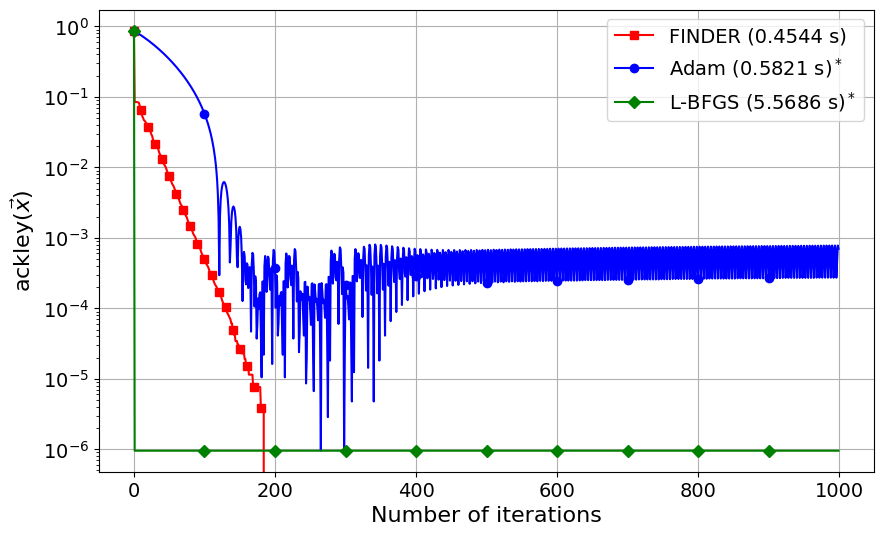

In [24]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()

plt.plot(fXX, 'rs-', markevery = 10, label = f'FINDER ({runtime_FINDER} s)')
plt.plot(fx_adam,'bo-', markevery = 100, label = f'Adam ({runtime_adam} s)$^*$')
plt.plot(fx_lbfgs,'gD-', markevery = 100, label = f'L-BFGS ({runtime_lbfgs} s)$^*$')

plt.ylabel("ackley($\\vec{x}$)", fontsize = 16)
plt.xlabel('Number of iterations', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.show()

# save data

In [25]:
xmean.shape[0]

5000

In [26]:
torch.save(torch.tensor(fXX), f'ackley_FINDER_N{xmean.shape[0]}_{runtime_FINDER}s.pt')

In [27]:
torch.save(torch.tensor(fx_adam), f'ackley_adam_N{xmean.shape[0]}_{runtime_adam}s.pt')

In [28]:
torch.save(torch.tensor(fx_lbfgs), f'ackley_lbfgs_N{xmean.shape[0]}_{runtime_lbfgs}s.pt')